In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass

from utils import TimeUnit, timer
from montecarlo import pi_monte_carlo, pi_monte_carlo_parallel_slow, pi_monte_carlo_parallel_fast

In [2]:
@dataclass
class SimulationState:
    ''' Dataclass for storing information about a Monte Carlo Pi simulation '''
    domain : int
    time_delta : float
    time_unit  : TimeUnit
    estimated_pi : float

In [3]:
def to_seconds(delta : float, unit : TimeUnit) -> float :
    ''' 
        Converts a time delta to seconds, given it's unit of time 

        args:
            delta : time delta to convert to seconds
            unit  : unit of time the delta is in
    '''
    scalar = None 

    match unit:
        case 'Seconds' : scalar = 0
        case 'Minutes' : scalar = 1
        case 'Hours'   : scalar = 2
        case _ : raise ValueError(f"Unknown time unit: {unit}")

    return delta * (60**scalar)

def run_simulations(domains : list[int], batch_size : int) -> tuple[list[SimulationState], ...] :
    ''' 
        Runs Monte Carlo Pi estimations for domains both sequential
        and in parallel to measure the time to run the estimation
        in both contexts for plotting
    '''
    
    def run_sequential(domain : int) -> SimulationState :
        
        estimated_pi, (delta, unit) = timer(pi_monte_carlo)(domain)

        return SimulationState(domain, delta, unit, estimated_pi)

    def run_parallel(domain : int, batch_size : int) -> SimulationState :
        
        estimated_pi, (delta, unit) = timer(pi_monte_carlo_parallel_fast)(domain, batch_size)

        return SimulationState(domain, delta, unit, estimated_pi)
    
    def run_parallel_bad(domain : int) -> SimulationState :

        estimated_pi, (delta, unit) = timer(pi_monte_carlo_parallel_slow)(domain)

        return SimulationState(domain, delta, unit, estimated_pi)

    sequential_states : list[SimulationState] = []
    parallel_states : list[SimulationState] = []
    # parallel_bad_states : list[SimulationState] = []

    for domain in domains:
        sequential_states.append(run_sequential(domain))
        parallel_states.append(run_parallel(domain, batch_size))
        # parallel_bad_states.append(run_parallel_bad(domain))

    return sequential_states, parallel_states#, parallel_bad_states


In [4]:
if __name__ == '__main__':
    sequential_results, parallel_results = run_simulations(domains=np.arange(start=100, stop=1000, step=100), batch_size=10_000)
    # sequential_results, parallel_results, parallel_results_bad = run_simulations(domains=[100, 200], batch_size=10_000)
    # domains = np.arange(start=1000, stop=10_001, step=100)
    # batch_size = 50_000
    # sequential_results, parallel_results, parallel_results_bad = run_simulations(domains=domains, batch_size=batch_size)

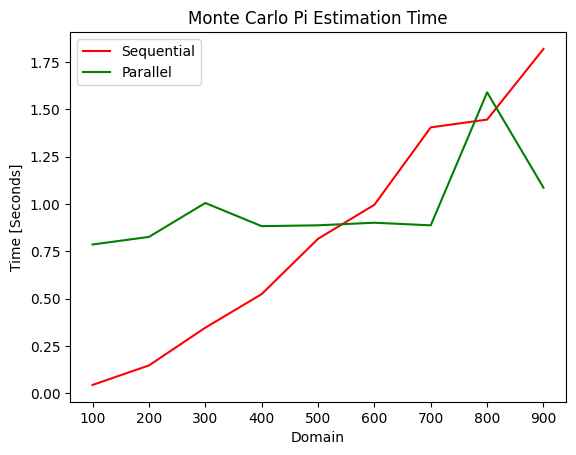

In [5]:
def plot_sequential_results(states : list[SimulationState]) -> None :

    x = [state.domain for state in states]
    y = [to_seconds(state.time_delta, state.time_unit) for state in states]
    
    plt.plot(x, y, label='Sequential', color='red')

def plot_parallel_results(states : list[SimulationState]) -> None :

    x = [state.domain for state in states]
    y = [to_seconds(state.time_delta, state.time_unit) for state in states]

    plt.plot(x, y, label='Parallel', color='green')

plot_sequential_results(sequential_results)
plot_parallel_results(parallel_results)

plt.title(label="Monte Carlo Pi Estimation Time")
plt.xlabel(xlabel="Domain")
plt.ylabel(ylabel="Time [Seconds]")
plt.legend(loc='best')

plt.show()